# Jupyter Note - Neural Style Transfer

**Author : Hon Wai Ting**

# Import packages & Create directories

In [6]:
import sys
import os

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import accelerate
from accelerate import Accelerator

# dvc = torch.device("cuda" if torch.cuda.is_available() else "cpu")
accelerator = Accelerator()
dvc = accelerator.device

# Print Device and Library Version
print(f"Using device: {dvc}")
print(f"Python version={sys.version}")
print(f"torch version={torch.__version__}")
print(f"torchvision version={torchvision.__version__}")
print(f"accelerate version={accelerate.__version__}")
print(f"matplotlib version={matplotlib.__version__}")

# Create Directory
INPUT_PATH="./inputs"
OUTPUT_PATH="./outputs"
CONFIG_PATH="./config"
os.makedirs(INPUT_PATH, exist_ok=True) # Input Directory
os.makedirs(OUTPUT_PATH, exist_ok=True) # Output Directory
os.makedirs(CONFIG_PATH, exist_ok=True) # Model Config Directory

Using device: cpu
Python version=3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:50:49) [Clang 16.0.6 ]
torch version=2.5.1
torchvision version=0.20.1
accelerate version=1.10.1
matplotlib version=3.10.0


# Google Drive Setup

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change the current working directory
import os;
os.chdir("/content/drive/MyDrive/Colab/Neural Style Transfer")
print(os.getcwd())

/content/drive/MyDrive/Colab/Neural Style Transfer


# Define the model aritechture for our task

## Import Pretrained model VGG19

In [27]:
vgg19_model = torchvision.models.vgg19(weights=torchvision.models.vgg.VGG19_Weights.DEFAULT)
print(vgg19_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## Build Our Own Architecture

In [28]:
# Keep Feature Extract Part Only
vgg19_model = vgg19_model.features

# desired depth layers to compute style/content losses :
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

model = nn.Sequential()

i = 0;
for layer in vgg19_model.children():
    if isinstance(layer, nn.Conv2d):
        i += 1
        name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)
        # The in-place version doesn't play very nicely with the ``ContentLoss``
        # and ``StyleLoss`` we insert below. So we replace with out-of-place
        # ones here.
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)
    else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)

# now we trim off the layers after the last content and style losses
for i, (name, layer) in enumerate(model.named_children(), 1):
    if name == max(style_layers):
        break

model = model[:(i)]

In [29]:
# Display and save the defined model
print(model)
torch.save(model, f"{CONFIG_PATH}/nst-model.pth") # Save the entire model

Sequential(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


# Inference

## Import our model from local directory

In [7]:
# Load Model from pth
neural_style_transfer_model = torch.load(f"{CONFIG_PATH}/nst-model.pth", weights_only=False, map_location=dvc)

# Disable Gradient and Turn Model to Evaluation Model
neural_style_transfer_model.requires_grad_(False)
neural_style_transfer_model.eval()
neural_style_transfer_model.to(dvc)
neural_style_transfer_model = accelerator.prepare(neural_style_transfer_model)

## Import Content and Style Images

Original image size: (1264, 1264)
New image size: (1264, 1264)
Original image size: (524, 502)
New image size: (502, 502)
style_image.shape: torch.Size([1, 3, 128, 128])
content_image.shape: torch.Size([1, 3, 128, 128])


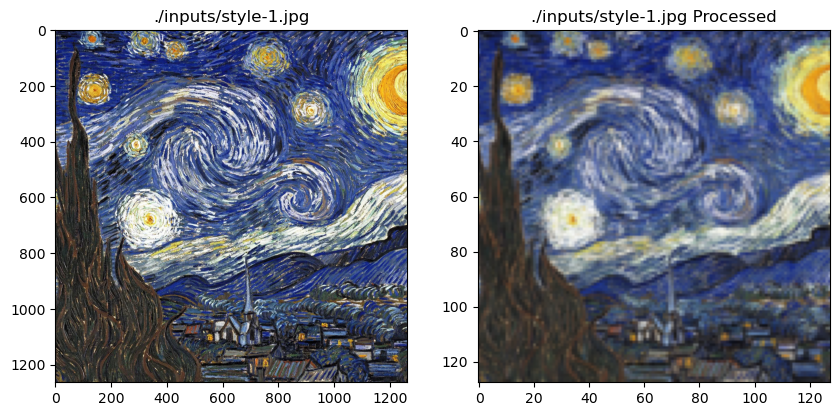

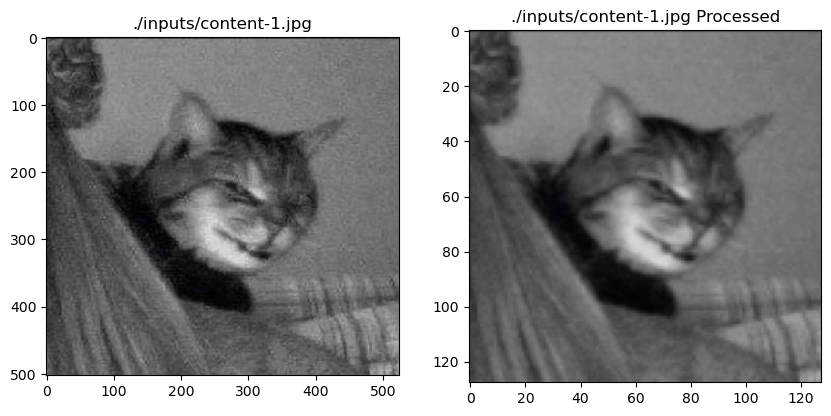

In [9]:
BIG_DIM=512
SMALL_DIM=128
image_dimension = BIG_DIM if torch.cuda.is_available() else SMALL_DIM

def image_to_tensor(image_filepath : str, image_dimension : int =SMALL_DIM) -> torch.Tensor:
    img = Image.open(image_filepath).convert('RGB')

    print(f"Original image size: {img.size}")

    # display image to check
    fig, axs = plt.subplots(1,2, figsize=(10, 6))
    axs[0].set_title(f"{image_filepath}")
    axs[0].imshow(img)

    # Central-crop the image if it is not square
    if img.height != img.width:
        width, height = img.size
        min_dim = min(width, height)
        left = (width - min_dim) / 2
        top = (height - min_dim) / 2
        right = (width + min_dim) / 2
        bottom = (height + min_dim) / 2
        box = (left, top, right, bottom)
        img = img.crop(box)

    # Scale-up image if it is too small
    if img.height < image_dimension or img.width < image_dimension:
      scaling_factor = image_dimension / max(img.size)

      new_width = int(img.width * scaling_factor)
      new_height = int(img.height * scaling_factor)

      img = img.resize((new_width, new_height), Image.LANCZOS)

    print(f"New image size: {img.size}")

    torch_transformation = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_dimension),
        torchvision.transforms.ToTensor()
    ])

    img = torch_transformation(img).unsqueeze(0)

    # Display Processed Image, Sub plt
    axs[1].set_title(f"{image_filepath} Processed")
    axs[1].imshow(img.squeeze(0).cpu().detach().numpy().transpose(1,2,0))

    return img.to(torch.float)

style_image = image_to_tensor(f"{INPUT_PATH}/style-1.jpg", image_dimension).to(dvc).detach()
content_image = image_to_tensor(f"{INPUT_PATH}/content-1.jpg", image_dimension).to(dvc).detach()
print(f"style_image.shape: {style_image.shape}")
print(f"content_image.shape: {content_image.shape}")

## Define input tensor

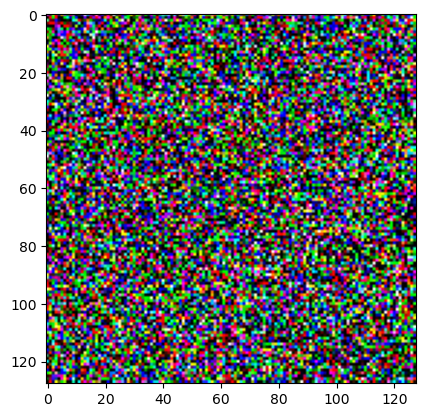

In [10]:
# initialize as the content image
# ip_image = content_image.clone().to(dvc)

# initialize as random noise:
ip_image = torch.randn(content_image.data.size(), device=dvc)

plt.figure()
plt.imshow(ip_image.squeeze(0).cpu().detach().numpy().transpose(1,2,0).clip(0,1));

## Inference Pipeline

### Define Functions and Variables before inference

In [ ]:
# Define Normalisation Function
normalise = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

In [12]:
# Define gram matrix
def gram_matrix(ip : torch.Tensor) -> torch.Tensor:
    num_batch, num_channels, height, width = ip.size()
    feats = ip.view(num_batch * num_channels, width * height)
    gram_mat = torch.mm(feats, feats.t())
    return gram_mat.div(num_batch * num_channels * width * height)

In [14]:
# desired depth layers to compute style/content losses :
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


### Do it

epoch number 50
style loss = 1108.282470703125, content loss = 80.14573669433594
epoch number 100
style loss = 134.4727783203125, content loss = 65.0513916015625
epoch number 150
style loss = 32.04461669921875, content loss = 63.58344268798828
epoch number 200
style loss = 15.354503631591797, content loss = 56.112674713134766


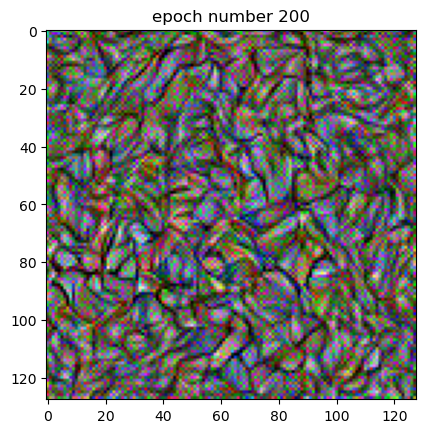

epoch number 250
style loss = 11.160995483398438, content loss = 49.145713806152344
epoch number 300
style loss = 8.702601432800293, content loss = 43.555606842041016
epoch number 350
style loss = 7.381526470184326, content loss = 39.748390197753906
epoch number 400
style loss = 6.464836120605469, content loss = 37.20924377441406


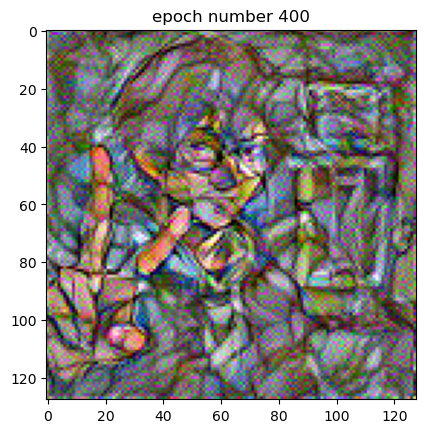

epoch number 450
style loss = 5.918536186218262, content loss = 35.473045349121094
epoch number 500
style loss = 5.494193077087402, content loss = 34.03567886352539
epoch number 550
style loss = 5.108542442321777, content loss = 33.085594177246094
epoch number 600
style loss = 4.836007118225098, content loss = 32.33739471435547


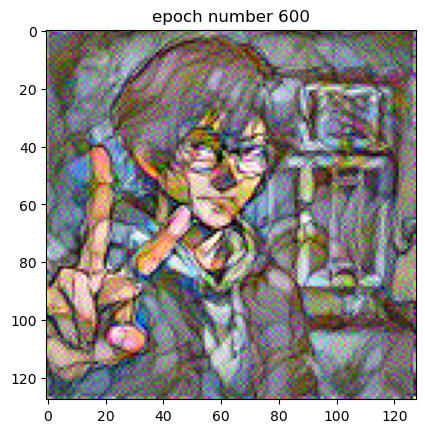

epoch number 650
style loss = 4.582333087921143, content loss = 31.784744262695312
epoch number 700
style loss = 4.462469100952148, content loss = 31.294776916503906
epoch number 750
style loss = 4.2721848487854, content loss = 31.098684310913086
epoch number 800
style loss = 4.17525053024292, content loss = 30.786195755004883


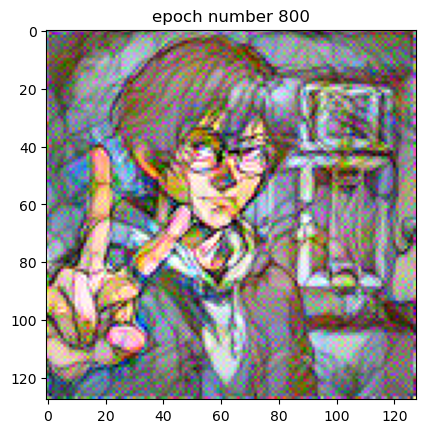

epoch number 850
style loss = 4.074538230895996, content loss = 30.639936447143555
epoch number 900
style loss = 4.033240795135498, content loss = 30.624053955078125
epoch number 950
style loss = 3.998929977416992, content loss = 30.573745727539062
epoch number 1000
style loss = 3.914846420288086, content loss = 30.623409271240234


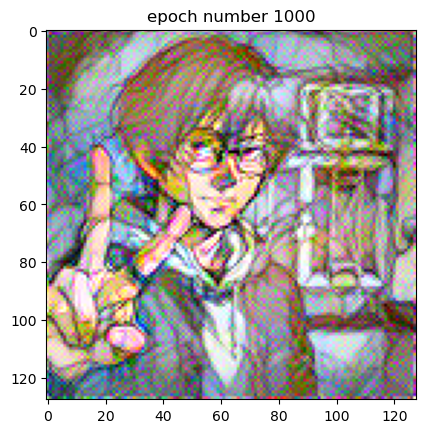

epoch number 1050
style loss = 3.9085192680358887, content loss = 30.663379669189453
epoch number 1100
style loss = 3.9028899669647217, content loss = 30.57079315185547
epoch number 1150
style loss = 5.479597568511963, content loss = 31.512405395507812
epoch number 1200
style loss = 3.8658413887023926, content loss = 30.5079345703125


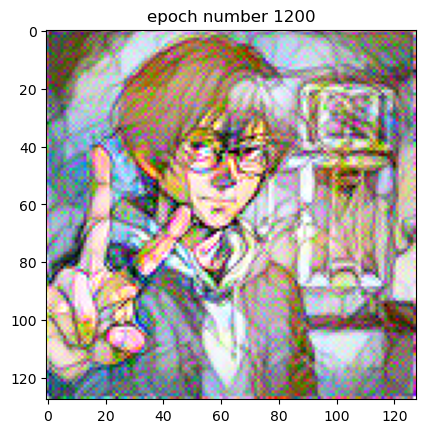

epoch number 1250
style loss = 3.8381288051605225, content loss = 30.265472412109375
epoch number 1300
style loss = 9207.4599609375, content loss = 126.45020294189453
epoch number 1350
style loss = 317.5809326171875, content loss = 62.381980895996094
epoch number 1400
style loss = 49.0455322265625, content loss = 57.64022445678711


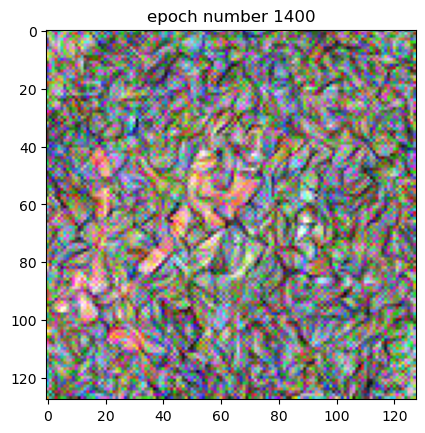

epoch number 1450
style loss = 12.552436828613281, content loss = 52.084476470947266
epoch number 1500
style loss = 7.768215656280518, content loss = 44.50905227661133


KeyboardInterrupt: 

In [37]:
%%time
num_epochs= 4000 if torch.cuda.is_available() else 2000
loss_checkpoint_step = 50
image_checkpoint_step = 200

epoch_style_losses = []
epoch_content_losses = []

ip_image.requires_grad_()

wt_style=1e4
wt_content=1
opt = optim.LBFGS([ip_image], lr=0.05)
opt = accelerator.prepare(opt)

for curr_epoch in range(1, num_epochs+1):
    ip_image.data.clamp_(0, 1)
    opt.zero_grad()

    epoch_style_loss = 0
    epoch_content_loss = 0

    x = ip_image
    c = content_image.detach()
    s = style_image.detach()

    x = normalise(x)
    c = normalise(c).detach()
    s = normalise(s).detach()

    for name, layer in neural_style_transfer_model.named_children():
        x = layer(x)
        c = layer(c).detach()
        s = layer(s).detach()
        if name in content_layers:
            epoch_content_loss += F.mse_loss(x, c.detach())
        if name in style_layers:
            epoch_style_loss += F.mse_loss(gram_matrix(x), gram_matrix(s).detach())

    epoch_style_loss *= wt_style
    epoch_content_loss *= wt_content

    total_loss = epoch_style_loss + epoch_content_loss
    accelerator.backward(total_loss)

    def closure() -> torch.Tensor:
        return total_loss

    if curr_epoch % loss_checkpoint_step == 0:
        epoch_style_losses += [epoch_style_loss.cpu().detach().numpy()]
        epoch_content_losses += [epoch_content_loss.cpu().detach().numpy()]
        print(f"epoch number {curr_epoch}")
        print(f"style loss = {epoch_style_loss}, content loss = {epoch_content_loss}")

    if curr_epoch % image_checkpoint_step == 0:
        display_image = ip_image.data.clamp_(0, 1).squeeze(0).cpu().detach()
        plt.figure()
        plt.title(f"epoch number {curr_epoch}")
        plt.imshow(display_image.numpy().transpose(1,2,0))
        plt.show()
        torchvision.utils.save_image(
            display_image,
            f"{OUTPUT_PATH}/image_{curr_epoch}.jpg"
        )

    opt.step(closure=closure)

## Plot Loss Curve

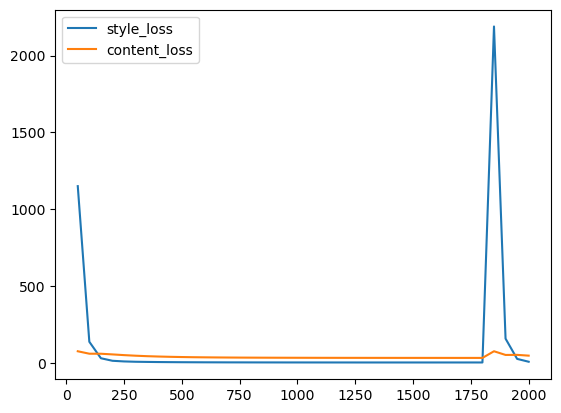

In [18]:
plt.plot(range(loss_checkpoint_step, num_epochs+1, loss_checkpoint_step), epoch_style_losses, label='style_loss');
plt.plot(range(loss_checkpoint_step, num_epochs+1, loss_checkpoint_step), epoch_content_losses, label='content_loss');
plt.legend();

# Foundings
- For style image, it must have very strong colour theme
  - More strong colour theme need lesser style weight
- VGG-19 is originally trained for 224x224 images. Therefore, Neural Style Transfer for 1024x1024 iamges perform very poorly .
- Gradient Explode

ToDos:
- Make it deployable

